This is a follow up to the experiments done in doggiestdog.ipynb. 

Last time around, we saw that a simple backpropagation method led to changes that lacked human meaning but significantly fooled the network. We also saw that alterations based on one network did not lead to the same error in a different network trained on the same data. 

In this notebook, we investigate what happens when we add more loss terms. One idea is to add a reconstruction loss that penalizes changes to the original input image. Obviously, this is at odds with our original loss, which requires changes to the input so that the image ultimately gets classified to the target class. This will lead to non-monotonically decreasing losses and may require some tuning of the loss weights before we can train stably. 

A second idea is to aggregate losses from multiple models to see if this has a more normalizing effect in the changes that are made. I doubt this will lead to our network making changes that have human meaning, but if this kind of training is successful, then we will have potentially have created the 'one poison that fits all'. 

# Setup

## Old Setup

Copied from doggiestdog.ipynb.

In [0]:
# @author: Mazda Moayeri

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np

We're on colab so we should be able to use a GPU. The following line sets the device appropriately and allows you to confirm that the device is GPU. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Pytorch's pretrained networks can be easily loaded with torchvision.models. They are all trained on ImageNet. 

Let's load a model! We need to set the model to eval so that its weights are unaltered as we train the input image.



In [3]:
resnet101 = models.resnet101(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


The networks trained on ImageNet expect inputs to match a specific distribution, so we will need to add a normalization layer at the very beginning.

In [0]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean#torch.tensor(mean).view(-1, 1, 1)
        self.std = std#torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
def norm_cnn(model):
  cnn = copy.deepcopy(model)
  normalization = Normalization(mean, std).to(device)
  out = nn.Sequential(normalization)
  out.add_module('cnn', cnn)
  return out


Some code for viewing images.

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=''):
    norm = (tensor-mean) / std
    image, norm = [unloader(x.cpu().clone().squeeze(0)) for x in [tensor, norm]]
    plt.subplot(121)
    plt.imshow(image)
    plt.title(title)
    plt.subplot(122)
    plt.imshow(norm)
    plt.title('Normalized')
    plt.pause(0.001) # pause a bit so that plots are updated

Let's make an input image. Some choices are random noise or a uniform color (white, black, gray). 

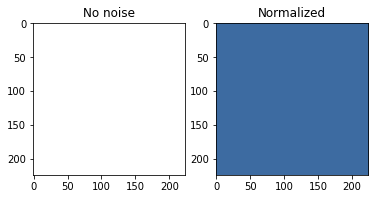

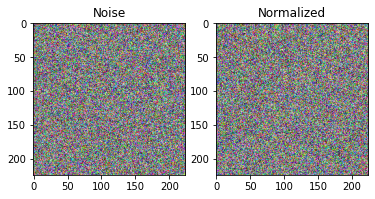

In [7]:
imsize = 224

def get_input_img(noise=False):
    if noise:
      img = torch.randn([1, 3, imsize, imsize], device=device)
    else:
      img = torch.ones([1, 3, imsize, imsize], device=device)

    return img

imshow(get_input_img(), title='No noise')
imshow(get_input_img(noise=True), title='Noise')

We also need to set our target. The class labels for ImageNet can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can do this in one line which will go in our training function.

In [0]:
target = torch.LongTensor([440]).to(device)

## Modifications to Previous Setup


Now we're going to make our own model, whose trainable parameters are just the pixels of the image we seek to generate.

We make two changes to what we had in our last notebook:



1.   Instead of feeding in a single model, we will now feed in a list of models. For each model, we compute the cross entropy loss between the predicted class by the current model for our input and the target.
2.   We include the option to have a penalty for making changes to the network. This will be achieved with a mean square error loss between the original input and the current input image. Thus, this loss will start at 0 and increase as the network makes more changes. We will include a parameter for the weight of this loss term relative to our usual loss.



In [0]:
def trainInputToTarget(target_ind, noise=False, title=None, input_img=None, lr=0.1, \
                       display=True, models=[resnet101], penalty_weight=0, thresh=0.99):
    ''' 
      target_ind -- what class we train our image to be classified to
      noise -- starts with random noise if True, otherwise starts with uniform img
      input_img -- when not None, we start with what is fed, and ignore noise param
      display -- when True, we print stats and the current img periodically
      models -- list of models to used to classify input image
      penalty_weight -- relative weight of penalty for making changes to input.
    '''

    target = torch.LongTensor([target_ind]).to(device)

    if input_img is None:
      input_img = get_input_img(noise)
    og_input = input_img.clone()
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=lr)
    criterion = nn.CrossEntropyLoss()
    cnns = [norm_cnn(model) for model in models]
    iteration = [0]
    max_num_steps = 500
    prob = [0]
    classification_losses = []
    penalties = []
    curr_pen = [0]
    while (prob[-1] < thresh or curr_pen[0] > 1) and iteration[0] <= max_num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss = 0
            sum_of_probs = 0
            for cnn in cnns:
                out = cnn(input_img)
                loss += criterion(out, target.detach())
                probs = F.softmax(out, dim=1)
                sum_of_probs += probs[0][target_ind]

            # prob[0] = sum_of_probs/len(cnns)
            prob.append(sum_of_probs/len(cnns))
            classification_losses.append(loss.item())
            
            if penalty_weight != 0:
                penalty = penalty_weight * F.mse_loss(input_img, og_input)
                curr_pen[0] = penalty.item()
                penalties.append(curr_pen[0])
                loss += penalty

            loss.backward()

            # let's figure out what probability our network thinks the current image
            # belongs to the target class

            if (iteration[0] % 10 == 0 or iteration[0] < 10 or \
                            (prob[-1] >= thresh and curr_pen[0] < 1)):
                msg ="iteration: {}.......P(in target class): {:.6f}.......Loss: {:.6f}" \
                      .format(iteration[0], prob[-1], classification_losses[-1])
                if penalty_weight != 0:
                    msg += ".......Penalty: {:.6f}".format(penalties[-1])
                print(msg)
                if display:
                  imshow(input_img, title)
            iteration[0] += 1
          
            return loss

        optimizer.step(closure)

        # print(prob[0] < 0.99 or curr_pen > 1)
        # print(prob[0].item(), curr_pen)
    if penalty_weight != 0:
      plt.figure(figsize=(12,6))
      plt.subplot(121)
      plt.plot(classification_losses, label='classification_loss')
      plt.plot(penalties, label='weighted perturbation penalty')
      plt.legend()
      plt.subplot(122)
      plt.plot(prob, label='probability in target')
      plt.plot(np.divide(penalties, penalty_weight), label='perturbation penalty')
      plt.legend()
      plt.show()
    input_img.data.clamp_(0, 1)
    imshow(input_img, title=title)
    return input_img

# Experiments for using Multiple Models


Let's load a bunch more models so we can see what happens when our loss is based on multiple cross entropy losses.

In [12]:
vgg19 = models.vgg19_bn(pretrained=True).to(device).eval()
vgg16 = models.vgg16_bn(pretrained=True).to(device).eval()
alexnet = models.alexnet(pretrained=True).to(device).eval()
squeezenet = models.squeezenet1_0(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


## Pugs

In [13]:
# 254 - pugs
pug_noise = trainInputToTarget(254, noise=True, title='pug', \
                               models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# 254 - pugs, not from noise now
pug = trainInputToTarget(254, title='pug', models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

## Spider Web

In [15]:
# 815 - spider's web
spider_web_noise = trainInputToTarget(815, noise=True, title='spider web', \
                                      models=[resnet101, alexnet, squeezenet, vgg19])
spider_web = trainInputToTarget(815, title='spider web', \
                                models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

## Soccer Ball

In [16]:
# 805 - soccer ball
soccer_ball_noise = trainInputToTarget(805, noise=True, title='soccer ball', \
                                      models=[resnet101, alexnet, squeezenet, vgg19])
soccer_ball = trainInputToTarget(805, title='soccer ball', \
                                models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

## Triumphal Arch

In [17]:
# 873 - triumphal arch
arch_noise = trainInputToTarget(873, noise=True, title='triumphal arch', \
                                      models=[resnet101, alexnet, squeezenet, vgg19])
arch = trainInputToTarget(873, title='triumphal arch', \
                                models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

## Bow Tie

In [18]:
# 457 - bow tie
bow_tie_noise = trainInputToTarget(457, noise=True, title='bow tie', \
                                      models=[resnet101, alexnet, squeezenet, vgg19])
bow_tie = trainInputToTarget(457, title='bow tie', \
                                models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

## School Bus

In [19]:
# 779 - school bus
school_bus_noise = trainInputToTarget(779, noise=True, title='school bus', \
                                      models=[resnet101, alexnet, squeezenet, vgg19])
school_bus = trainInputToTarget(779, title='school bus', \
                                models=[resnet101, alexnet, squeezenet, vgg19])

Output hidden; open in https://colab.research.google.com to view.

# Discussion

It's still kind of nonesense, though we expected this. Just figured we should give it a shot!






# Part Two - starting off on a better foot

Executive summary of findings:



*   Backprop changes the input image to noise, even when we start with an input that should be close to the target class.
*   Image space is too big and decision boundaries are not smooth. The subset of real images in the entire image space is swiss-cheese like, so moving directly in the image space likely leads to wandering into the garbage subset of the image space. 
*   Networks should be able to recognize garbage, but traditionally we don't train for that, because our evaluation metrics were completely unaffected by how the network behaves on inputs that are outside the distribution of the training data. If we want networks to work on anything (which they must do in the real world), they definitely should have a mechanism to handle this failure mode. At the least, classifiers should have a class for 'unrecognized' or 'garbage' inputs. 


## More Setup - meet my pup Rainier!
__________________

The setup is the exact same as in doggiestdog.ipynb

Some code for loading actual images. 

In [0]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize), # crop to make square
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [20]:
def rainier():
  rainier = image_loader('/content/rainier.jpg')
  return rainier

cnn = norm_cnn(resnet101)
out = cnn(rainier())
_, pred = torch.max(out, 1)
print(F.softmax(out, dim=1)[0][pred])
print(pred)

tensor([0.5986], device='cuda:0', grad_fn=<IndexBackward>)
tensor([266], device='cuda:0')


## Experiments - now with a penalty against changing the original image too much

In [20]:
# 254 - pugs
_ = trainInputToTarget(target_ind=254, input_img=rainier(), title='Rainier to Pug', \
                       penalty_weight=100)

Output hidden; open in https://colab.research.google.com to view.

Very interesting -- the training first makes perturbations to increase the activation on the target class node, but then recovers much of the original image to satisfy the constraint on the maximum penalty. The cool part is that in the latter stage of training, where the network is making changes to decrease the penalty, we see that the background of the image is restored. This checks out, as the background could be the exact same for Rainier to be a pug or a goldendoodle. In other words, the targeted changes necessary to make Rainier look like a pug would only be in his face, which is what the network ultimately does. 

In [21]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 100)

Output hidden; open in https://colab.research.google.com to view.

Again, the same result! Perturbations are restricted to the face area and we have shown that we can still fool the neural networks without making too many changes to the original image. 

Something else of note is that it seems like if we trained for longer, the penalty would continue to decrease without compromising our classification loss. This way, we can make truly imperciptible changes to an image that dramatically fool the networks.

iteration: 0.......P(in target class): 0.000000.......Loss: 15.694484.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.026492.......Loss: 3.630929.......Penalty: 9.507927
iteration: 2.......P(in target class): 0.908249.......Loss: 0.096237.......Penalty: 21.920284
iteration: 3.......P(in target class): 0.940765.......Loss: 0.061062.......Penalty: 34.760494
iteration: 4.......P(in target class): 0.944638.......Loss: 0.056953.......Penalty: 45.889870
iteration: 5.......P(in target class): 0.962187.......Loss: 0.038547.......Penalty: 54.810471
iteration: 6.......P(in target class): 0.964024.......Loss: 0.036639.......Penalty: 61.504894
iteration: 7.......P(in target class): 0.975810.......Loss: 0.024487.......Penalty: 66.146667
iteration: 8.......P(in target class): 0.982264.......Loss: 0.017896.......Penalty: 68.993805
iteration: 9.......P(in target class): 0.987016.......Loss: 0.013069.......Penalty: 70.314423
iteration: 10.......P(in target class): 0.990007.......Loss: 

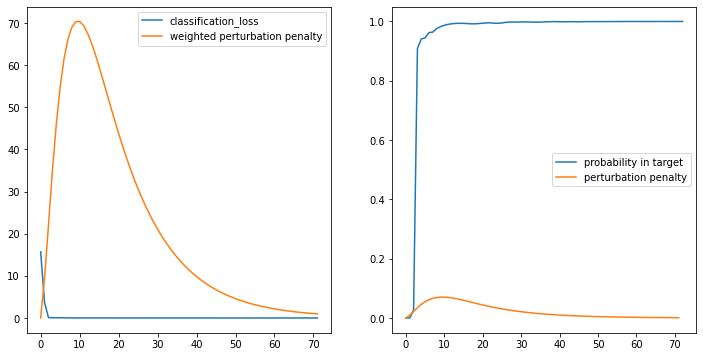

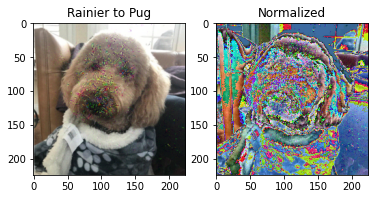

In [22]:
# 254 - pug
_ = trainInputToTarget(target_ind=254, input_img=rainier(), display=False, \
                       title='Rainier to Pug', penalty_weight=1000)

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307915.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.000363.......Loss: 7.920036.......Penalty: 9.506566
iteration: 2.......P(in target class): 0.003887.......Loss: 5.550101.......Penalty: 22.616827
iteration: 3.......P(in target class): 0.730341.......Loss: 0.314244.......Penalty: 35.260258
iteration: 4.......P(in target class): 0.926032.......Loss: 0.076847.......Penalty: 46.532333
iteration: 5.......P(in target class): 0.886809.......Loss: 0.120126.......Penalty: 55.768723
iteration: 6.......P(in target class): 0.882164.......Loss: 0.125377.......Penalty: 62.824303
iteration: 7.......P(in target class): 0.963242.......Loss: 0.037451.......Penalty: 67.763199
iteration: 8.......P(in target class): 0.982140.......Loss: 0.018021.......Penalty: 70.823372
iteration: 9.......P(in target class): 0.989643.......Loss: 0.010410.......Penalty: 72.266121
iteration: 10.......P(in target class): 0.993864.......Loss: 

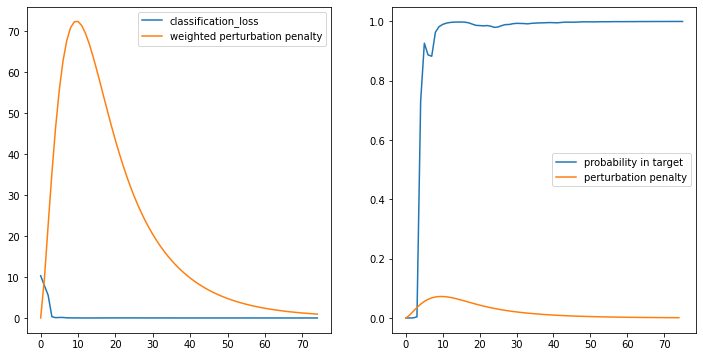

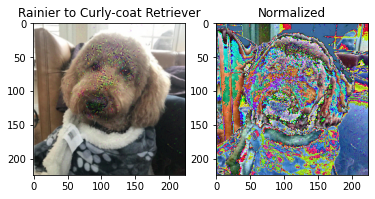

In [23]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1000)

Can we get even more imperceptible?

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307915.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.000363.......Loss: 7.920033.......Penalty: 9506.566406
iteration: 2.......P(in target class): 0.002014.......Loss: 6.207642.......Penalty: 884.494812
iteration: 3.......P(in target class): 0.000000.......Loss: 22.426104.......Penalty: 1652.640747
iteration: 4.......P(in target class): 0.000008.......Loss: 11.738932.......Penalty: 4936.058594
iteration: 5.......P(in target class): 0.000166.......Loss: 8.703234.......Penalty: 4031.876465
iteration: 6.......P(in target class): 0.000444.......Loss: 7.719954.......Penalty: 1359.586182
iteration: 7.......P(in target class): 0.000000.......Loss: 14.600441.......Penalty: 86.032928
iteration: 8.......P(in target class): 0.006417.......Loss: 5.048832.......Penalty: 962.690247
iteration: 9.......P(in target class): 0.002935.......Loss: 5.831037.......Penalty: 2305.126465
iteration: 10.......P(in target class): 0.0

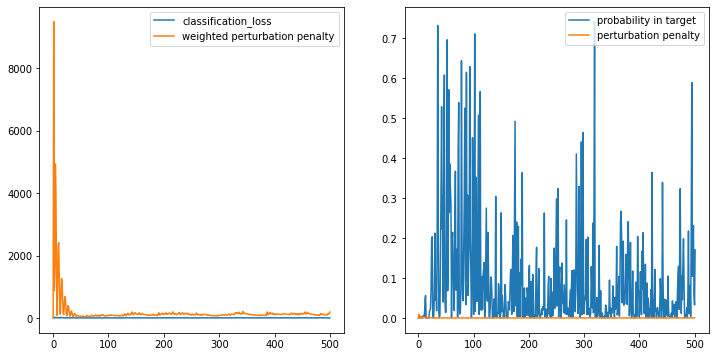

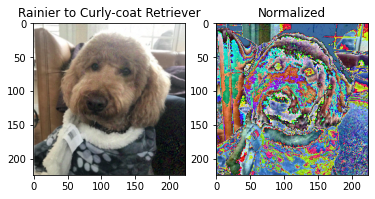

In [24]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1e6)

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307915.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.000363.......Loss: 7.920034.......Penalty: 950.656616
iteration: 2.......P(in target class): 0.004488.......Loss: 5.406444.......Penalty: 432.293823
iteration: 3.......P(in target class): 0.023143.......Loss: 3.766079.......Penalty: 251.917175
iteration: 4.......P(in target class): 0.071309.......Loss: 2.640735.......Penalty: 385.639008
iteration: 5.......P(in target class): 0.654634.......Loss: 0.423678.......Penalty: 402.379181
iteration: 6.......P(in target class): 0.345077.......Loss: 1.063989.......Penalty: 274.139069
iteration: 7.......P(in target class): 0.171814.......Loss: 1.761343.......Penalty: 151.449097
iteration: 8.......P(in target class): 0.061927.......Loss: 2.781795.......Penalty: 127.268120
iteration: 9.......P(in target class): 0.027631.......Loss: 3.588827.......Penalty: 181.687851
iteration: 10.......P(in target class): 0.383366...

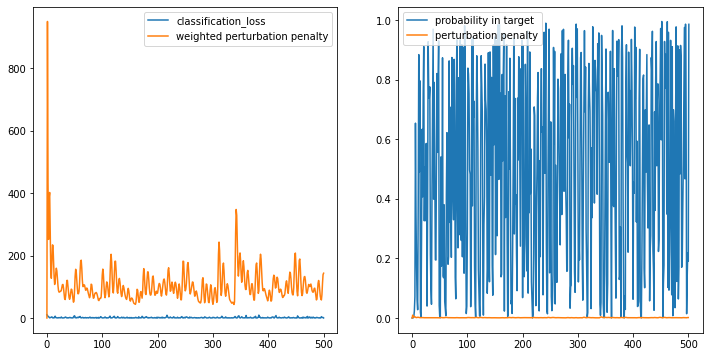

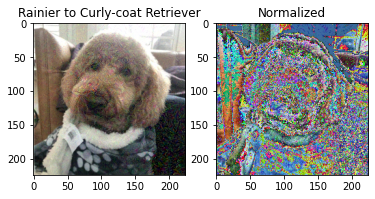

In [25]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1e5)

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307915.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.000363.......Loss: 7.920031.......Penalty: 95.065659
iteration: 2.......P(in target class): 0.002511.......Loss: 5.986989.......Penalty: 178.571915
iteration: 3.......P(in target class): 0.829737.......Loss: 0.186646.......Penalty: 215.502060
iteration: 4.......P(in target class): 0.952920.......Loss: 0.048224.......Penalty: 217.835785
iteration: 5.......P(in target class): 0.953562.......Loss: 0.047551.......Penalty: 201.799408
iteration: 6.......P(in target class): 0.938954.......Loss: 0.062989.......Penalty: 178.019196
iteration: 7.......P(in target class): 0.908878.......Loss: 0.095545.......Penalty: 153.206589
iteration: 8.......P(in target class): 0.913581.......Loss: 0.090383.......Penalty: 130.812347
iteration: 9.......P(in target class): 0.932403.......Loss: 0.069990.......Penalty: 112.043198
iteration: 10.......P(in target class): 0.824726....

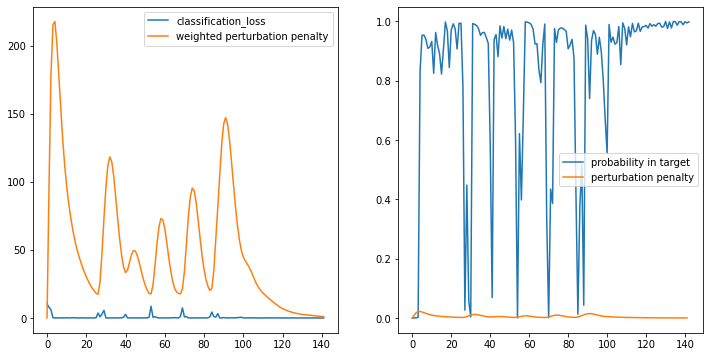

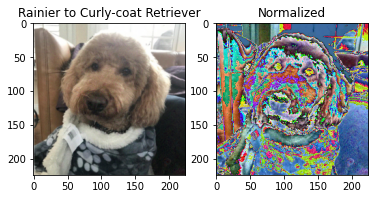

In [26]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1e4)

So 1e5 and 1e6 were unnecessarily high, as a weight of 1e4 on the penalty was sufficient to have perturbations be imperciptible (at least to me). I wonder if we can make training any smoother by using a lower learning rate, and also decreasing the requirement of how highly the network classifies the final image in the given task. 

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307915.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.014816.......Loss: 4.212016.......Penalty: 9.778794
iteration: 2.......P(in target class): 0.523738.......Loss: 0.646763.......Penalty: 19.257467
iteration: 3.......P(in target class): 0.897293.......Loss: 0.108373.......Penalty: 24.785259
iteration: 4.......P(in target class): 0.965353.......Loss: 0.035261.......Penalty: 26.569643
iteration: 5.......P(in target class): 0.981396.......Loss: 0.018779.......Penalty: 25.916477
iteration: 6.......P(in target class): 0.984884.......Loss: 0.015231.......Penalty: 23.881184
iteration: 7.......P(in target class): 0.978717.......Loss: 0.021512.......Penalty: 21.244444
iteration: 8.......P(in target class): 0.964633.......Loss: 0.036008.......Penalty: 18.503546
iteration: 9.......P(in target class): 0.952166.......Loss: 0.049016.......Penalty: 15.933285
iteration: 10.......P(in target class): 0.929268.......Loss: 

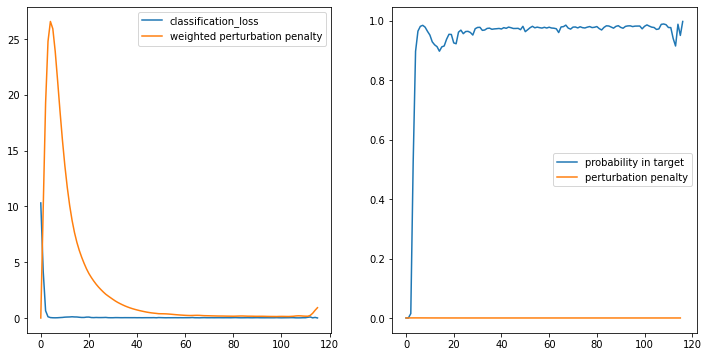

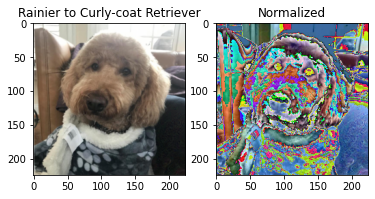

In [27]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, lr=1e-2, \
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1e5)

iteration: 0.......P(in target class): 0.000033.......Loss: 10.307916.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.014816.......Loss: 4.212014.......Penalty: 0.977879
iteration: 2.......P(in target class): 0.483991.......Loss: 0.725689.......Penalty: 2.295768
iteration: 3.......P(in target class): 0.859569.......Loss: 0.151324.......Penalty: 3.752095
iteration: 4.......P(in target class): 0.964633.......Loss: 0.036008.......Penalty: 5.188030
iteration: 5.......P(in target class): 0.980597.......Loss: 0.019594.......Penalty: 6.477488
iteration: 6.......P(in target class): 0.982048.......Loss: 0.018116.......Penalty: 7.558649
iteration: 7.......P(in target class): 0.981104.......Loss: 0.019077.......Penalty: 8.410286
iteration: 8.......P(in target class): 0.983776.......Loss: 0.016357.......Penalty: 9.034503
iteration: 9.......P(in target class): 0.988171.......Loss: 0.011900.......Penalty: 9.446995
iteration: 10.......P(in target class): 0.991945.......Loss: 0.008087

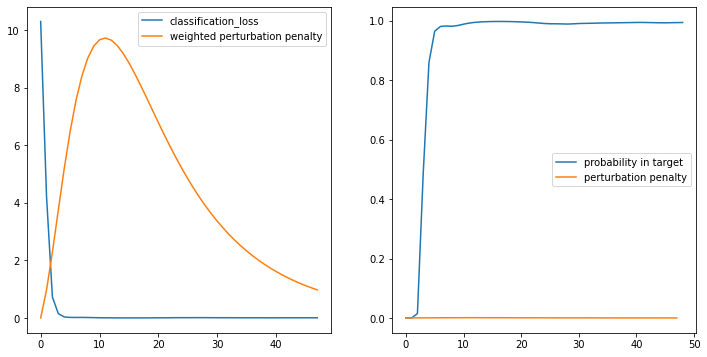

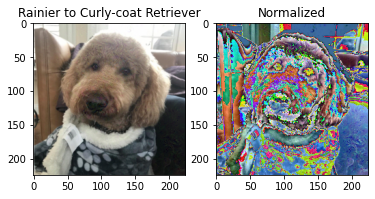

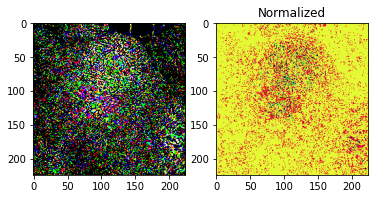

In [21]:
# 206 - curly coat retriever, a closer relative
rainierRetriever = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, lr=1e-2, thresh=0.75,\
                       title='Rainier to Curly-coat Retriever', penalty_weight = 1e4)
imshow(rainier()-rainierRetriever)

Cool! Now training is quicker and the final image is still imperceptible. Let's see what happens if we choose a more arbitrary target class.

iteration: 0.......P(in target class): 0.000001.......Loss: 13.628322.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.929567.......Loss: 0.073036.......Penalty: 0.978022
iteration: 2.......P(in target class): 0.999916.......Loss: 0.000084.......Penalty: 2.542025
iteration: 3.......P(in target class): 0.999948.......Loss: 0.000051.......Penalty: 4.094208
iteration: 4.......P(in target class): 0.999965.......Loss: 0.000034.......Penalty: 5.448956
iteration: 5.......P(in target class): 0.999965.......Loss: 0.000034.......Penalty: 6.549925
iteration: 6.......P(in target class): 0.999960.......Loss: 0.000040.......Penalty: 7.392534
iteration: 7.......P(in target class): 0.999955.......Loss: 0.000044.......Penalty: 7.995221
iteration: 8.......P(in target class): 0.999950.......Loss: 0.000050.......Penalty: 8.385962
iteration: 9.......P(in target class): 0.999943.......Loss: 0.000057.......Penalty: 8.595676
iteration: 10.......P(in target class): 0.999930.......Loss: 0.000071

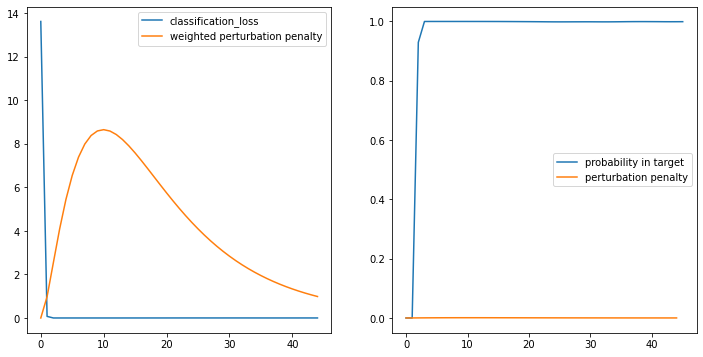

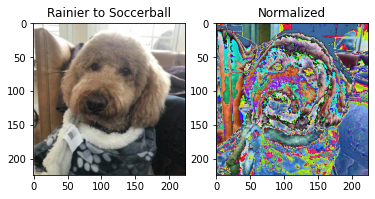

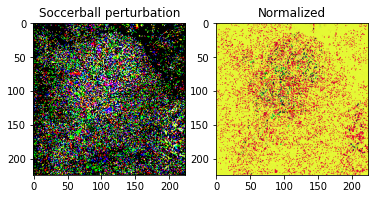

In [22]:
# 805 - soccer ball
rainierSoccer = trainInputToTarget(target_ind=805, input_img=rainier(), display=False, lr=.01,\
                       title='Rainier to Soccerball', penalty_weight = 1e4, thresh=0.98)
imshow(rainierSoccer-rainier(), title='Soccerball perturbation')

## Discussion




Wow! We can efficiently make imperceptible targeted perturbations. Now let's put part 1 and part 2 together. 

# Part Three - Multiple Models and Perturbation Penalty

This is what we've been waiting for. The goal here is to make perturbations that are imperceptible and can also fool multiple models. Let's get right to our experiments.

iteration: 0.......P(in target class): 0.000007.......Loss: 54.145382.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.404170.......Loss: 8.076136.......Penalty: 0.978640
iteration: 2.......P(in target class): 0.968955.......Loss: 0.127182.......Penalty: 2.435098
iteration: 3.......P(in target class): 0.984614.......Loss: 0.062570.......Penalty: 4.128756
iteration: 4.......P(in target class): 0.986252.......Loss: 0.055922.......Penalty: 5.806119
iteration: 5.......P(in target class): 0.986639.......Loss: 0.054277.......Penalty: 7.353839
iteration: 6.......P(in target class): 0.987088.......Loss: 0.052368.......Penalty: 8.719008
iteration: 7.......P(in target class): 0.987829.......Loss: 0.049282.......Penalty: 9.879363
iteration: 8.......P(in target class): 0.988678.......Loss: 0.045801.......Penalty: 10.830101
iteration: 9.......P(in target class): 0.989848.......Loss: 0.041031.......Penalty: 11.577254
iteration: 10.......P(in target class): 0.991091.......Loss: 0.0359

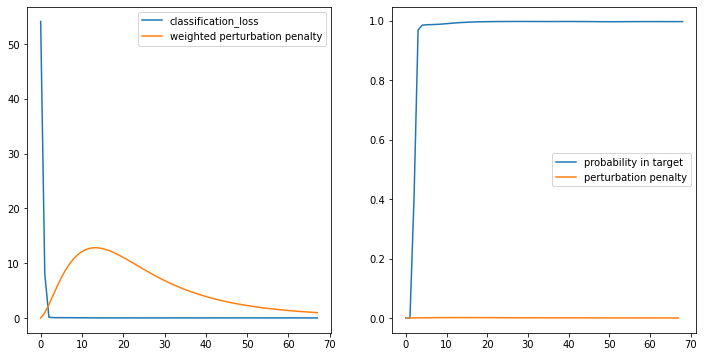

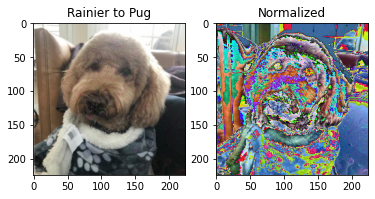

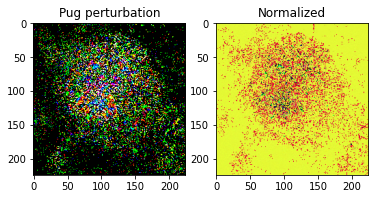

In [23]:
# 254 - triumphal arc
rainierPug = trainInputToTarget(target_ind=254, input_img=rainier(), display=False, lr=.01,\
                       title='Rainier to Pug', penalty_weight = 1e4, thresh=0.9, \
                       models = [vgg19, resnet101, alexnet, squeezenet])
imshow(rainierPug-rainier(), title='Pug perturbation')

iteration: 0.......P(in target class): 0.000854.......Loss: 43.660805.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.025762.......Loss: 15.441113.......Penalty: 0.978612
iteration: 2.......P(in target class): 0.535196.......Loss: 2.948680.......Penalty: 2.306544
iteration: 3.......P(in target class): 0.792179.......Loss: 1.032435.......Penalty: 3.820792
iteration: 4.......P(in target class): 0.955944.......Loss: 0.183815.......Penalty: 5.386304
iteration: 5.......P(in target class): 0.970967.......Loss: 0.118583.......Penalty: 6.917128
iteration: 6.......P(in target class): 0.975304.......Loss: 0.100400.......Penalty: 8.335742
iteration: 7.......P(in target class): 0.977107.......Loss: 0.092863.......Penalty: 9.600047
iteration: 8.......P(in target class): 0.978270.......Loss: 0.088007.......Penalty: 10.689040
iteration: 9.......P(in target class): 0.979998.......Loss: 0.080885.......Penalty: 11.595481
iteration: 10.......P(in target class): 0.982836.......Loss: 0.069

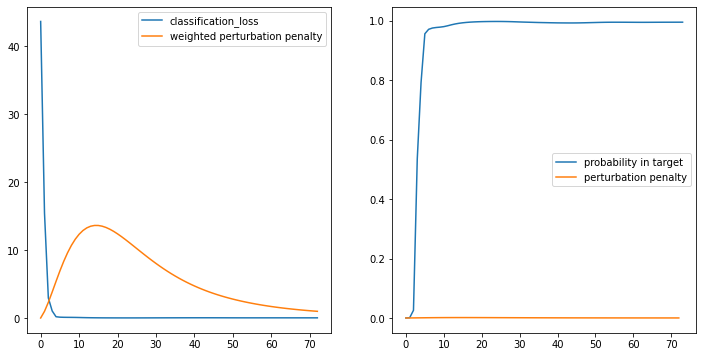

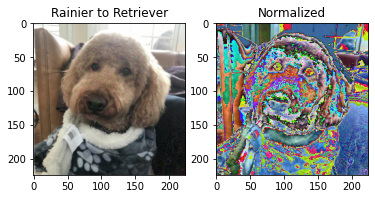

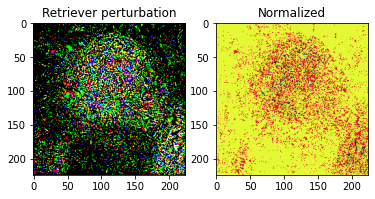

In [24]:
# 206 - curly coat retriever
rainierRetriever = trainInputToTarget(target_ind=206, input_img=rainier(), display=False, lr=.01,\
                       title='Rainier to Retriever', penalty_weight = 1e4, thresh=0.9, \
                       models = [vgg19, resnet101, alexnet, squeezenet])
imshow(rainierRetriever-rainier(), title='Retriever perturbation')

iteration: 0.......P(in target class): 0.000186.......Loss: 41.967484.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.387904.......Loss: 5.499140.......Penalty: 0.978485
iteration: 2.......P(in target class): 0.843144.......Loss: 0.979690.......Penalty: 2.433060
iteration: 3.......P(in target class): 0.966499.......Loss: 0.142923.......Penalty: 4.143026
iteration: 4.......P(in target class): 0.981876.......Loss: 0.074353.......Penalty: 5.870336
iteration: 5.......P(in target class): 0.983906.......Loss: 0.065390.......Penalty: 7.490655
iteration: 6.......P(in target class): 0.984301.......Loss: 0.063640.......Penalty: 8.941654
iteration: 7.......P(in target class): 0.986330.......Loss: 0.055334.......Penalty: 10.194485
iteration: 8.......P(in target class): 0.988381.......Loss: 0.046978.......Penalty: 11.239669
iteration: 9.......P(in target class): 0.990324.......Loss: 0.039073.......Penalty: 12.079034
iteration: 10.......P(in target class): 0.992143.......Loss: 0.031

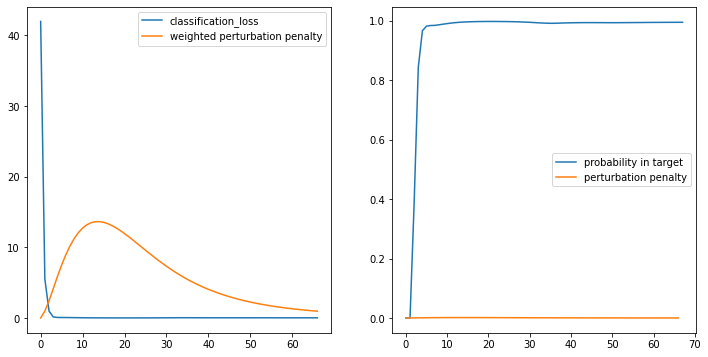

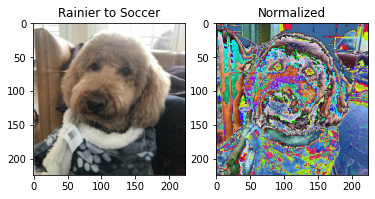

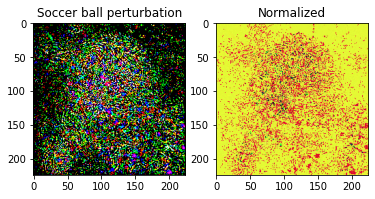

In [25]:
# 805 - soccer ball
rainierSoccer = trainInputToTarget(target_ind=805, input_img=rainier(), display=False, lr=.01,\
                       title='Rainier to Soccer', penalty_weight = 1e4, thresh=0.9, \
                       models = [vgg19, resnet101, alexnet, squeezenet])
imshow(rainierSoccer-rainier(), title='Soccer ball perturbation')

iteration: 0.......P(in target class): 0.000000.......Loss: 74.812042.......Penalty: 0.000000
iteration: 1.......P(in target class): 0.000186.......Loss: 38.862083.......Penalty: 0.978739
iteration: 2.......P(in target class): 0.099498.......Loss: 17.157282.......Penalty: 2.373345
iteration: 3.......P(in target class): 0.629339.......Loss: 7.494535.......Penalty: 3.939693
iteration: 4.......P(in target class): 0.709958.......Loss: 5.243120.......Penalty: 5.626515
iteration: 5.......P(in target class): 0.728060.......Loss: 3.785907.......Penalty: 7.312706
iteration: 6.......P(in target class): 0.748026.......Loss: 2.597207.......Penalty: 8.924345
iteration: 7.......P(in target class): 0.788174.......Loss: 1.542824.......Penalty: 10.418480
iteration: 8.......P(in target class): 0.851973.......Loss: 0.806974.......Penalty: 11.769470
iteration: 9.......P(in target class): 0.901673.......Loss: 0.463045.......Penalty: 12.956981
iteration: 10.......P(in target class): 0.931435.......Loss: 0.3

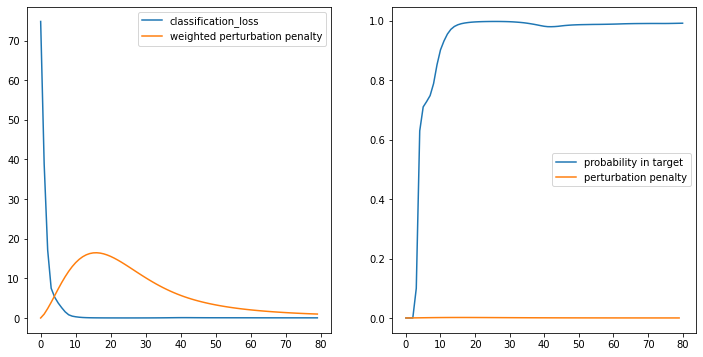

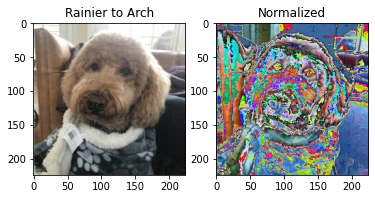

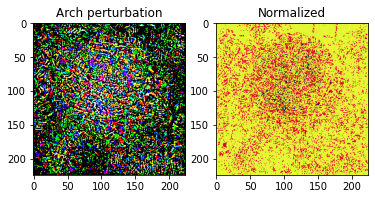

In [26]:
# 873 - triumphal arch
rainierArc = trainInputToTarget(target_ind=873, input_img=rainier(), display=False, lr=.01,\
                       title='Rainier to Arch', penalty_weight = 1e4, thresh=0.9, \
                       models = [vgg19, resnet101, alexnet, squeezenet])
imshow(rainierArc-rainier(), title='Arch perturbation')

#Part Four - one poison fits all?

## Setup and Motivation

This is the same setup as from doggiestdog.ipynb. Here's what was running through my mind at the time when I wrote the code:
______

I'm often curious about whether or not data poisoning is a real problem if it requires knowledge of and access to the network. There very well may be more sophisticated poisoning methods that don't require direct access to the network (I'm not very well read re: adversarial deep learning), but could it be the case that an adversarial example generated from one network could fool a different network? 

We can put this to the test! The experiment we are setting up here is giving all the leverage to the poisoners, since the networks that we'll try to poison were all trained on the same dataset (ImageNet). 

In [0]:
def classify(model, img, model_name):
  cnn = norm_cnn(model)
  out = cnn(img)
  _, pred = torch.max(out, 1)
  print('{:<15s} {:<15d} {:<15f}'.format(model_name,pred.item(),F.softmax(out, dim=1)[0][pred].item()))

def display_model_predictions(imgs, models):
  for img_key in imgs.keys():
    print('_'*60)
    print('Target class: {}'.format(img_key))
    print('{:<15s} {:<15s} {:<15s}'.format('Model','Pred. Class','Probability'))
    for model_name in models.keys():
      classify(models[model_name], imgs[img_key], model_name)

Let's load some more models that our input images weren't trained on. Note that by design, the generated images will be classified to the desired target for alexnet, squeezenet, resnet101, and vgg19. We need some control models to see if the posion transfers -- right now we only have vgg16.

In [37]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True).to(device).eval()
resnet50 = models.resnet50(pretrained=True).to(device).eval()
resnet152 = models.resnet152(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


## Experiment 1: Images Generated from Uniform Input


In [38]:
imgs = {254:pug, 815:spider_web, 873:arch, 805:soccer_ball, 457:bow_tie, 779:school_bus}
models = {'vgg19':vgg19, 'vgg16':vgg16, 'alexnet':alexnet, 'squeezenet':squeezenet, \
          'resnet18':resnet18, 'resnet50':resnet50, 'resnet152':resnet152}

display_model_predictions(imgs, models)

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           254             0.988648       
vgg16           489             0.134298       
alexnet         254             0.990502       
squeezenet      254             0.996412       
resnet18        971             0.108079       
resnet50        971             0.170571       
resnet152       556             0.634028       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg19           815             0.991477       
vgg16           824             0.058513       
alexnet         815             0.991815       
squeezenet      815             0.995923       
resnet18        611             0.126462       
resnet50        904             0.240137       
resnet152       556             0.412667       
____________________________________________________________
Target class:

## Images from Noise

In [39]:
imgs_from_noise = {254:pug_noise, 815:spider_web_noise, 873:arch_noise, \
        805:soccer_ball_noise, 457:bow_tie_noise, 779:school_bus_noise}
display_model_predictions(imgs_from_noise, models)

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           254             0.996374       
vgg16           904             0.701944       
alexnet         254             0.981656       
squeezenet      254             0.997244       
resnet18        971             0.781996       
resnet50        971             0.843340       
resnet152       904             0.109854       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg19           815             0.991561       
vgg16           904             0.603820       
alexnet         815             0.993932       
squeezenet      815             0.994562       
resnet18        971             0.664960       
resnet50        971             0.399916       
resnet152       490             0.245984       
____________________________________________________________
Target class:

## Rainier Experiments

In [40]:
imgs = {206:rainierRetriever, 254:rainierPug, 873:rainierArc, 805:rainierSoccer}

display_model_predictions(imgs, models)

____________________________________________________________
Target class: 206
Model           Pred. Class     Probability    
vgg19           206             0.998639       
vgg16           206             0.378282       
alexnet         206             0.989405       
squeezenet      206             0.995355       
resnet18        206             0.243368       
resnet50        209             0.238650       
resnet152       267             0.522258       
____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           254             0.999467       
vgg16           254             0.592531       
alexnet         254             0.991546       
squeezenet      254             0.997642       
resnet18        676             0.086955       
resnet50        254             0.608351       
resnet152       200             0.194634       
____________________________________________________________
Target class:

## Discussion

Even when we use multiple different networks, we can't make poisons that work across networks that were not used during training. This raises the question, if we can only generate adversarial examples with access to the network, is a sufficent defense against adversarial examples just keeping the network a secret? 

We should admit that there was some success in transferring poison. Specifically, Rainier -> curly coat retriever worked on vgg16 and resnet18, and Rainier -> pug worked on vgg16 and resnet50. However, it most definitely helps that Rainier is a dog, so it's a much smaller mistake to misclassify him as a different breed of dog, as opposed to saying he is a soccer ball.  